In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import sys, os
import numpy as np
import pandas as pd
from datetime import datetime as dt
from collections import Counter
from sklearn.preprocessing import scale
import bandicoot_dev as bc_d
from py_pcha.PCHA import PCHA
from sklearn import decomposition
from build_dataset.analysis.outlier_detection import Outlier_detector_svm, Outlier_detector_kd
from build_dataset.extractors.big_five_extractor import Big_five_extractor

import bandicoot_dev as bc_d

## Debugging

tc0 = {
    'hours': range(24),
    'days': range(7),
    'spans': [
        ("01/01/14", "31/12/14")
    ]
}

def compute_features(userid, tc="tc0", groupby="week", summary="special"):
    
    user = bc_d.read_csv(
        "%d" % userid, 
        call_path="build_dataset/data_cache/records/call/%s/" % tc,
        text_path="build_dataset/data_cache/records/text/%s/" % tc,
        physical_path="build_dataset/data_cache/records/physical/%s/" % tc,
        screen_path="build_dataset/data_cache/records/screen/%s/" % tc,
        stop_path="build_dataset/data_cache/records/stop/%s/" % tc, 
        network=False,
        describe=False
    )
    
    indicators = bc_d.utils.all(
        user,
        groupby=groupby,
        summary=summary,
        dist=True,
        network=False,
        spatial=False
    )

    for ex in ['name', 'reporting']:
        del indicators[ex]

    return bc_d.utils.flatten(indicators), user


ds, user = compute_features(0)

w0_call = user.start_time['call'].date().isocalendar()[1]-1
w0_text = user.start_time['text'].date().isocalendar()[1]-1
w0_physical = user.start_time['physical'].date().isocalendar()[1]-1
w0_screen = user.start_time['screen'].date().isocalendar()[1]-1
w0_stop = user.start_time['stop'].date().isocalendar()[1]-1

wt_call = user.end_time['call'].date().isocalendar()[1]-1
wt_text = user.end_time['text'].date().isocalendar()[1]-1
wt_physical = user.end_time['physical'].date().isocalendar()[1]-1
wt_screen = user.end_time['screen'].date().isocalendar()[1]-1
wt_stop = user.end_time['stop'].date().isocalendar()[1]-1

print "call", w0_call, wt_call
print "text", w0_text, wt_text
print "physical", w0_physical, wt_physical
print "screen", w0_screen, wt_screen
print "stop", w0_stop, wt_stop

In [2]:
tc0 = {
    'hours': range(24),
    'days': range(7),
    'spans': [
        ("01/01/14", "31/12/14")
    ],
    'weeks': range(53)
}
tc1 = {
    'hours': range(24),
    'days': range(7),
    'spans': [
        ("06/01/14", "24/01/14"),
        ("03/02/14", "16/05/14"),
        ("01/09/14", "05/12/14"),
        ("02/06/14", "20/06/14")
    ],
    'weeks': range(1, 4) + \
             range(5, 16) + \
             range(17, 20) + \
             range(22, 25) + \
             range(35, 40) + \
             range(41, 49)
}
tc2 = {
    'hours': range(24),
    'days': range(7),
    'spans': [
        ("17/05/14", "01/06/14"),
        ("06/12/14", "21/12/14")
    ],
    'weeks': range(20, 22) + \
             range(49, 52)
}
tc3 = {
    'hours': range(24),
    'days': range(7),
    'spans': [
        ("01/01/14", "05/01/14"),
        ("25/01/14", "02/02/14"),
        ("14/04/14", "20/04/14"),
        ("21/06/14", "30/08/14"),
        ("22/12/14", "31/12/14")
    ],
    'weeks': range(0, 1) + \
             range(4, 5) + \
             range(16, 17) + \
             range(25, 35) + \
             range(40, 41) + \
             range(52, 53)
}

## Compute features

In [10]:
def compute_features(userid, tc="tc0", groupby="week", summary="special"):
    
    user = bc_d.read_csv(
        "%d" % userid, 
        call_path="build_dataset/data_cache/records/call/%s/" % tc,
        text_path="build_dataset/data_cache/records/text/%s/" % tc,
        physical_path="build_dataset/data_cache/records/physical/%s/" % tc,
        screen_path="build_dataset/data_cache/records/screen/%s/" % tc,
        stop_path="build_dataset/data_cache/records/stop/%s/" % tc, 
        network=False,
        describe=False
    )
    
    user.start_time['any'] = dt.strptime('01/01/14', "%d/%m/%y")
    user.end_time['any'] = dt.strptime('01/01/15', "%d/%m/%y")
    
    indicators = bc_d.utils.all(
        user,
        groupby=groupby,
        summary=summary,
        dist=True,
        network=False,
        spatial=False
    )

    for ex in ['name', 'reporting']:
        del indicators[ex]

    return bc_d.utils.flatten(indicators), user

def processed_users(tc):
    interaction_types = ["call", "text", "physical", "screen", "stop"]
    counter = Counter()
    for t in interaction_types:
        users = [int(f.split(".")[0]) for f in os.listdir("build_dataset/data_cache/records/%s/%s" % (t, tc))]
        counter.update(users)
    return [k for k,v in counter.items() if v == 5]

def get_periods(tc, groupby):
    """Only works for tc0!"""
    if groupby == "week":
        period = 7
    if groupby == "month":
        period = 30
    if groupby == "year":
        period = 365
    span = tc['spans'][0]
    delta = dt.strptime(span[1], "%d/%m/%y") - \
            dt.strptime(span[0], "%d/%m/%y")
    return int(np.ceil(delta.days/period)) + 1

def interpolate_nans(X):
    """Overwrite NaNs with column value interpolations."""
    for j in range(X.shape[1]):
        mask_j = np.isnan(X[:,j])
        try:
            X[mask_j,j] = np.interp(np.flatnonzero(mask_j), np.flatnonzero(~mask_j), X[~mask_j,j])
        except ValueError:
            X[mask_j,j] = 0
    return X

big_five = Big_five_extractor()

users = processed_users("tc0")
users_tmp = users
groupby = "week"
l = 0
for u in sorted(users_tmp):
    print "\n", u
    
    ds, user = compute_features(u, groupby=groupby)
    
    # Initiate
    if l == 0:
        M = len(ds) + sum([1 for v in ds.values() if type(v[0]) is dict])  # Indicators
        N = get_periods(tc0, groupby)
        L = len(users_tmp)
        feat_names = []
        X = np.empty((N, M, L))
        Y = np.empty((1, 5, L))

    U = np.full((N, M), None)
    
    c = 0
    for m, (f, vals) in enumerate(ds.items()):
        if l == 0:
            if type(vals[0]) is dict:
                feat_names.append(f + "_mean")
                feat_names.append(f + "_std")
            else:
                feat_names.append(f)

        for n, v in enumerate(vals):
            # v is either [int, int, int, ...], or [dict, dict, dict, ...]
            if type(v) is dict:
                U[n, m + c] = v['mean']
                U[n, m + c + 1] = v['std']
                increment_c = True
            else:
                U[n, m + c] = v
                increment_c = False
        
        if increment_c:
            c += 1
    
    try:
        X[:, :, l] = U
        Y[:, :, l] = big_five.main(u)
        l+=1
    except:
        print "User", u, "skipped"
        
X = X[:, :, :l+1]
X.dump("data/X_2014_%s.pickle" % groupby)

[big_five_extractor] Loaded data from local copy!

0

1

2

3

4

5

6

7

8

9

10

11

12

13

14

15

16

17

18

19

20

21

22

23

24

25
Grouping by week, but all data is from the same week!

26

27

28

29

30

31

32

33

34

35

36

37

38

39

40

42

43

44

45

46

47

48

49

50

51

52

53

54

55

56

57

58

59

60

61

62

63

64

65

66

67

68

69

70

71

72

73

74

75

76

77

78

79

80

81

82

83

84

85

86

87

88

89

90

91

92

93

94

95

96

97

98

99

100

101

102

103
Grouping by week, but all data is from the same week!

104

105

106

107

108

109

110

111

112

113

114

115

116

117

118

119

120

121

122

123

124

125

126

127

128

129

130

131

132

133

134
Grouping by week, but all data is from the same week!

135

136

137

138

139

140

141

142

143

144

145

146

147

148

149

150

151

152

153

154

155

156

157

158

159

160

161

162

163

164

165

166

167

168

169

170

171

172

173

174

175

177

178

179

180

1

KeyError: '5b7b4bd33d4913997887d2f4c529e8'

### Interpolate nans

In [13]:
for l in range(X.shape[2]):
    mask_i = ~np.all(np.isnan(X[:, :, l]) | np.equal(X[:, :, l], 0), axis=1)
    X[mask_i, :, l] = interpolate_nans(X[mask_i, :, l])

### Average over respective periods on axis=0, zscore and save

In [94]:
X_users_mean_tc0 = np.nanmean(X[:, :, :],axis=0).T
X_users_mean_tc0 = scale(X_users_mean_tc0[~np.isnan(X_users_mean_tc0).any(axis=1)])
np.savetxt("data/X_users_mean_tc0.csv", X_users_mean_tc0, delimiter=",")

X_users_mean_tc1 = np.nanmean(X[tc1['weeks'], :, :],axis=0).T
X_users_mean_tc1 = scale(X_users_mean_tc1[~np.isnan(X_users_mean_tc1).any(axis=1)])
np.savetxt("data/X_users_mean_tc1.csv", X_users_mean_tc1, delimiter=",")

X_users_mean_tc2 = np.nanmean(X[tc2['weeks'], :, :],axis=0).T
X_users_mean_tc2 = scale(X_users_mean_tc2[~np.isnan(X_users_mean_tc2).any(axis=1)])
np.savetxt("data/X_users_mean_tc2.csv", X_users_mean_tc2, delimiter=",")

X_users_mean_tc3 = np.nanmean(X[tc3['weeks'], :, :],axis=0).T
X_users_mean_tc3 = scale(X_users_mean_tc3[~np.isnan(X_users_mean_tc3).any(axis=1)])
np.savetxt("data/X_users_mean_tc3.csv", X_users_mean_tc3, delimiter=",")

### Display indicator labels

In [146]:
#index_from = 0
#zip(range(index_from, len(feat_names)+index_from),feat_names)

### Detect outliers

In [103]:
out_tc0_svm = Outlier_detector_svm(X_users_mean_tc0, hard=False, threshold=-1, visualize=False, nu=0.1, gamma=0.25)
out_tc0_kd = Outlier_detector_kd(X_users_mean_tc0, visualize=False, threshold=0.08, bandwidth=2, kernel='gaussian')
outliers_tc0_svm = out_tc0_svm.main()
outliers_tc0_kd = out_tc0_kd.main()

X_users_mean_tc0_clean_svm = np.delete(X_users_mean_tc0,outliers_tc0_svm,axis=0)
X_users_mean_tc0_clean_kd = np.delete(X_users_mean_tc0,outliers_tc0_kd,axis=0)

print "[svm tc0] Removed %d outliers, clean subset has %d samples" % (
    (X_users_mean_tc0.shape[0]-X_users_mean_tc0_clean_svm.shape[0]), X_users_mean_tc0_clean_svm.shape[0])
np.savetxt("data/X_users_mean_tc0_clean_svm.csv", X_users_mean_tc0_clean_kd, delimiter=",")
print "[kd tc0] Removed %d outliers, clean subset has %d samples" % (
    (X_users_mean_tc0.shape[0]-X_users_mean_tc0_clean_kd.shape[0]), X_users_mean_tc0_clean_kd.shape[0])
np.savetxt("data/X_users_mean_tc0_clean_kd.csv", X_users_mean_tc0_clean_kd, delimiter=",")


out_tc1_svm = Outlier_detector_svm(X_users_mean_tc1, hard=False, threshold=-1, visualize=False, nu=0.1, gamma=0.25)
out_tc1_kd = Outlier_detector_kd(X_users_mean_tc1, visualize=False, threshold=0.08, bandwidth=2, kernel='gaussian')
outliers_tc1_svm = out_tc1_svm.main()
outliers_tc1_kd = out_tc1_kd.main()

X_users_mean_tc1_clean_svm = np.delete(X_users_mean_tc1,outliers_tc1_svm,axis=0)
X_users_mean_tc1_clean_kd = np.delete(X_users_mean_tc1,outliers_tc1_kd,axis=0)

print "[svm tc1] Removed %d outliers, clean subset has %d samples" % (
    (X_users_mean_tc1.shape[0]-X_users_mean_tc1_clean_svm.shape[0]), X_users_mean_tc1_clean_svm.shape[0])
np.savetxt("data/X_users_mean_tc1_clean_svm.csv", X_users_mean_tc1_clean_kd, delimiter=",")
print "[kd tc1] Removed %d outliers, clean subset has %d samples" % (
    (X_users_mean_tc1.shape[0]-X_users_mean_tc1_clean_kd.shape[0]), X_users_mean_tc1_clean_kd.shape[0])
np.savetxt("data/X_users_mean_tc1_clean_kd.csv", X_users_mean_tc1_clean_kd, delimiter=",")


out_tc2_svm = Outlier_detector_svm(X_users_mean_tc2, hard=False, threshold=-1, visualize=False, nu=0.1, gamma=0.25)
out_tc2_kd = Outlier_detector_kd(X_users_mean_tc2, visualize=False, threshold=0.08, bandwidth=2, kernel='gaussian')
outliers_tc2_svm = out_tc2_svm.main()
outliers_tc2_kd = out_tc2_kd.main()

X_users_mean_tc2_clean_svm = np.delete(X_users_mean_tc2,outliers_tc2_svm,axis=0)
X_users_mean_tc2_clean_kd = np.delete(X_users_mean_tc2,outliers_tc2_kd,axis=0)

print "[svm tc2] Removed %d outliers, clean subset has %d samples" % (
    (X_users_mean_tc2.shape[0]-X_users_mean_tc2_clean_svm.shape[0]), X_users_mean_tc2_clean_svm.shape[0])
np.savetxt("data/X_users_mean_tc2_clean_svm.csv", X_users_mean_tc2_clean_kd, delimiter=",")
print "[kd tc2] Removed %d outliers, clean subset has %d samples" % (
    (X_users_mean_tc2.shape[0]-X_users_mean_tc2_clean_kd.shape[0]), X_users_mean_tc2_clean_kd.shape[0])
np.savetxt("data/X_users_mean_tc2_clean_kd.csv", X_users_mean_tc2_clean_kd, delimiter=",")


out_tc3_svm = Outlier_detector_svm(X_users_mean_tc3, hard=False, threshold=-1, visualize=False, nu=0.1, gamma=0.25)
out_tc3_kd = Outlier_detector_kd(X_users_mean_tc3, visualize=False, threshold=0.08, bandwidth=2, kernel='gaussian')
outliers_tc3_svm = out_tc3_svm.main()
outliers_tc3_kd = out_tc3_kd.main()

X_users_mean_tc3_clean_svm = np.delete(X_users_mean_tc3,outliers_tc3_svm,axis=0)
X_users_mean_tc3_clean_kd = np.delete(X_users_mean_tc3,outliers_tc3_kd,axis=0)

print "[svm tc3] Removed %d outliers, clean subset has %d samples" % (
    (X_users_mean_tc3.shape[0]-X_users_mean_tc3_clean_svm.shape[0]), X_users_mean_tc3_clean_svm.shape[0])
np.savetxt("data/X_users_mean_tc3_clean_svm.csv", X_users_mean_tc3_clean_kd, delimiter=",")
print "[kd tc3] Removed %d outliers, clean subset has %d samples" % (
    (X_users_mean_tc3.shape[0]-X_users_mean_tc3_clean_kd.shape[0]), X_users_mean_tc3_clean_kd.shape[0])
np.savetxt("data/X_users_mean_tc3_clean_kd.csv", X_users_mean_tc3_clean_kd, delimiter=",")

[svm tc0] Removed 26 outliers, clean subset has 654 samples
[kd tc0] Removed 54 outliers, clean subset has 626 samples
[svm tc1] Removed 29 outliers, clean subset has 651 samples
[kd tc1] Removed 54 outliers, clean subset has 626 samples
[svm tc2] Removed 14 outliers, clean subset has 605 samples
[kd tc2] Removed 49 outliers, clean subset has 570 samples
[svm tc3] Removed 28 outliers, clean subset has 651 samples
[kd tc3] Removed 54 outliers, clean subset has 625 samples


# Show archetypes

### PCA + PCHA for each individual tc


tc0


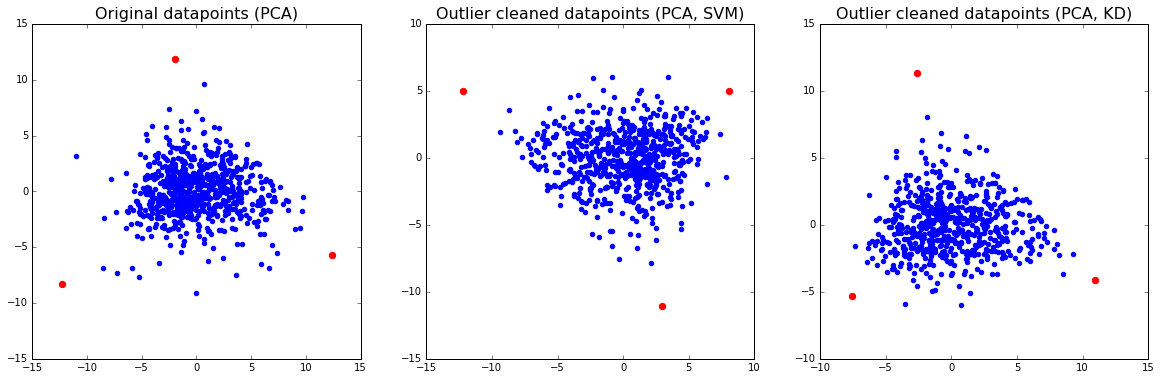


tc1


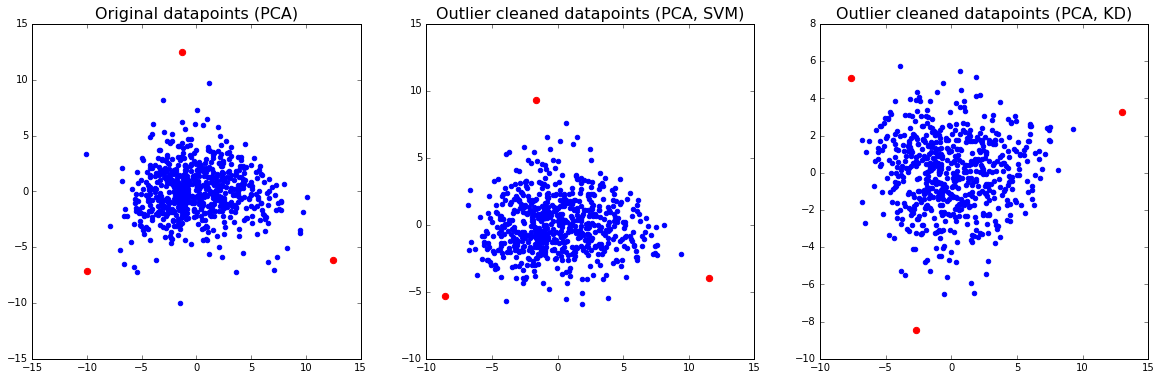


tc2


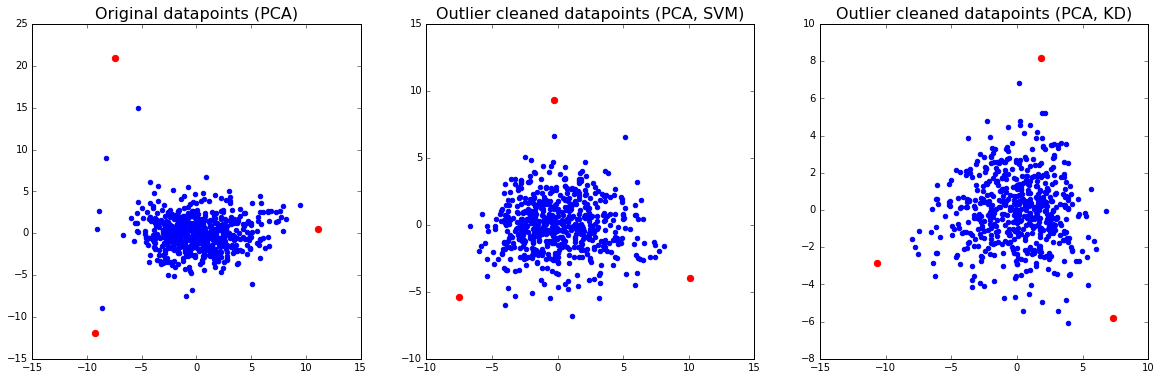


tc3


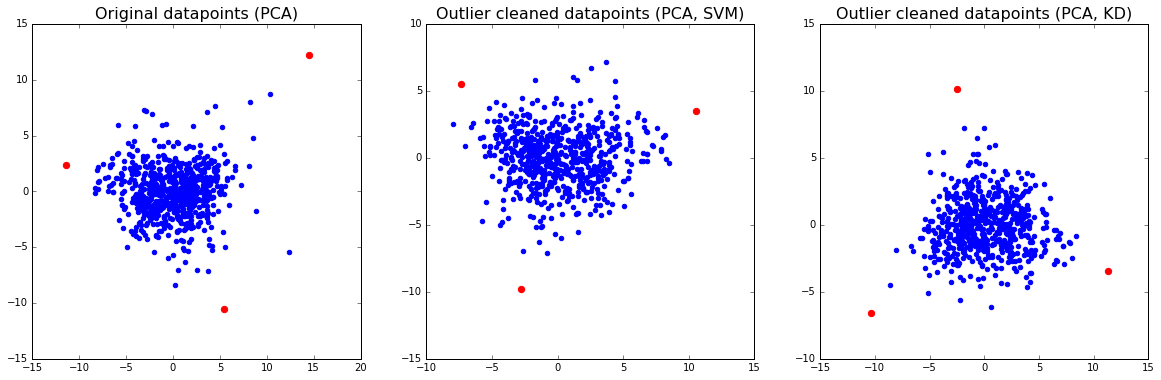

In [102]:
print "\ntc0"

plt.figure(0, figsize=(20,6))

plt.subplot(1,3,1)
plt.title("Original datapoints (PCA)", fontsize=16)

pca = decomposition.PCA(n_components=2)
X0 = X_users_mean_tc0
pca.fit(X0)
X0 = pca.transform(X0)
XC, S, C, SSE, varexpl = PCHA(X0.T, 3, delta=0.4)

plt.scatter(X0[:, 0], X0[:, 1], color="b")
plt.scatter(XC[0, :], XC[1, :], color="r", s=40)


plt.subplot(1,3,2)
plt.title("Outlier cleaned datapoints (PCA, SVM)", fontsize=16)

pca = decomposition.PCA(n_components=2)
X0 = X_users_mean_tc0_clean_svm
pca.fit(X0)
X0 = pca.transform(X0)
XC, S, C, SSE, varexpl = PCHA(X0.T, 3, delta=0.4)

plt.scatter(X0[:, 0], X0[:, 1], color="b")
plt.scatter(XC[0, :], XC[1, :], color="r", s=40)


plt.subplot(1,3,3)
plt.title("Outlier cleaned datapoints (PCA, KD)", fontsize=16)

pca = decomposition.PCA(n_components=2)
X0 = X_users_mean_tc0_clean_kd
pca.fit(X0)
X0 = pca.transform(X0)
XC, S, C, SSE, varexpl = PCHA(X0.T, 3, delta=0.4)

plt.scatter(X0[:, 0], X0[:, 1], color="b")
plt.scatter(XC[0, :], XC[1, :], color="r", s=40)

plt.show()

print "\ntc1"

plt.figure(1, figsize=(20,6))

plt.subplot(1,3,1)
plt.title("Original datapoints (PCA)", fontsize=16)

pca = decomposition.PCA(n_components=2)
X0 = X_users_mean_tc1
pca.fit(X0)
X0 = pca.transform(X0)
XC, S, C, SSE, varexpl = PCHA(X0.T, 3, delta=0.4)

plt.scatter(X0[:, 0], X0[:, 1], color="b")
plt.scatter(XC[0, :], XC[1, :], color="r", s=40)


plt.subplot(1,3,2)
plt.title("Outlier cleaned datapoints (PCA, SVM)", fontsize=16)

pca = decomposition.PCA(n_components=2)
X0 = X_users_mean_tc1_clean_svm
pca.fit(X0)
X0 = pca.transform(X0)
XC, S, C, SSE, varexpl = PCHA(X0.T, 3, delta=0.4)

plt.scatter(X0[:, 0], X0[:, 1], color="b")
plt.scatter(XC[0, :], XC[1, :], color="r", s=40)


plt.subplot(1,3,3)
plt.title("Outlier cleaned datapoints (PCA, KD)", fontsize=16)

pca = decomposition.PCA(n_components=2)
X0 = X_users_mean_tc1_clean_kd
pca.fit(X0)
X0 = pca.transform(X0)
XC, S, C, SSE, varexpl = PCHA(X0.T, 3, delta=0.4)

plt.scatter(X0[:, 0], X0[:, 1], color="b")
plt.scatter(XC[0, :], XC[1, :], color="r", s=40)

plt.show()

print "\ntc2"

plt.figure(2, figsize=(20,6))

plt.subplot(1,3,1)
plt.title("Original datapoints (PCA)", fontsize=16)

pca = decomposition.PCA(n_components=2)
X0 = X_users_mean_tc2
pca.fit(X0)
X0 = pca.transform(X0)
XC, S, C, SSE, varexpl = PCHA(X0.T, 3, delta=0.4)

plt.scatter(X0[:, 0], X0[:, 1], color="b")
plt.scatter(XC[0, :], XC[1, :], color="r", s=40)


plt.subplot(1,3,2)
plt.title("Outlier cleaned datapoints (PCA, SVM)", fontsize=16)

pca = decomposition.PCA(n_components=2)
X0 = X_users_mean_tc2_clean_svm
pca.fit(X0)
X0 = pca.transform(X0)
XC, S, C, SSE, varexpl = PCHA(X0.T, 3, delta=0.4)

plt.scatter(X0[:, 0], X0[:, 1], color="b")
plt.scatter(XC[0, :], XC[1, :], color="r", s=40)


plt.subplot(1,3,3)
plt.title("Outlier cleaned datapoints (PCA, KD)", fontsize=16)

pca = decomposition.PCA(n_components=2)
X0 = X_users_mean_tc2_clean_kd
pca.fit(X0)
X0 = pca.transform(X0)
XC, S, C, SSE, varexpl = PCHA(X0.T, 3, delta=0.4)

plt.scatter(X0[:, 0], X0[:, 1], color="b")
plt.scatter(XC[0, :], XC[1, :], color="r", s=40)

plt.show()

print "\ntc3"

plt.figure(3, figsize=(20,6))

plt.subplot(1,3,1)
plt.title("Original datapoints (PCA)", fontsize=16)

pca = decomposition.PCA(n_components=2)
X0 = X_users_mean_tc3
pca.fit(X0)
X0 = pca.transform(X0)
XC, S, C, SSE, varexpl = PCHA(X0.T, 3, delta=0.4)

plt.scatter(X0[:, 0], X0[:, 1], color="b")
plt.scatter(XC[0, :], XC[1, :], color="r", s=40)


plt.subplot(1,3,2)
plt.title("Outlier cleaned datapoints (PCA, SVM)", fontsize=16)

pca = decomposition.PCA(n_components=2)
X0 = X_users_mean_tc3_clean_svm
pca.fit(X0)
X0 = pca.transform(X0)
XC, S, C, SSE, varexpl = PCHA(X0.T, 3, delta=0.4)

plt.scatter(X0[:, 0], X0[:, 1], color="b")
plt.scatter(XC[0, :], XC[1, :], color="r", s=40)


plt.subplot(1,3,3)
plt.title("Outlier cleaned datapoints (PCA, KD)", fontsize=16)

pca = decomposition.PCA(n_components=2)
X0 = X_users_mean_tc3_clean_kd
pca.fit(X0)
X0 = pca.transform(X0)
XC, S, C, SSE, varexpl = PCHA(X0.T, 3, delta=0.4)

plt.scatter(X0[:, 0], X0[:, 1], color="b")
plt.scatter(XC[0, :], XC[1, :], color="r", s=40)

plt.show()

### All tc datasets projected onto PC1/PC2 for tc0

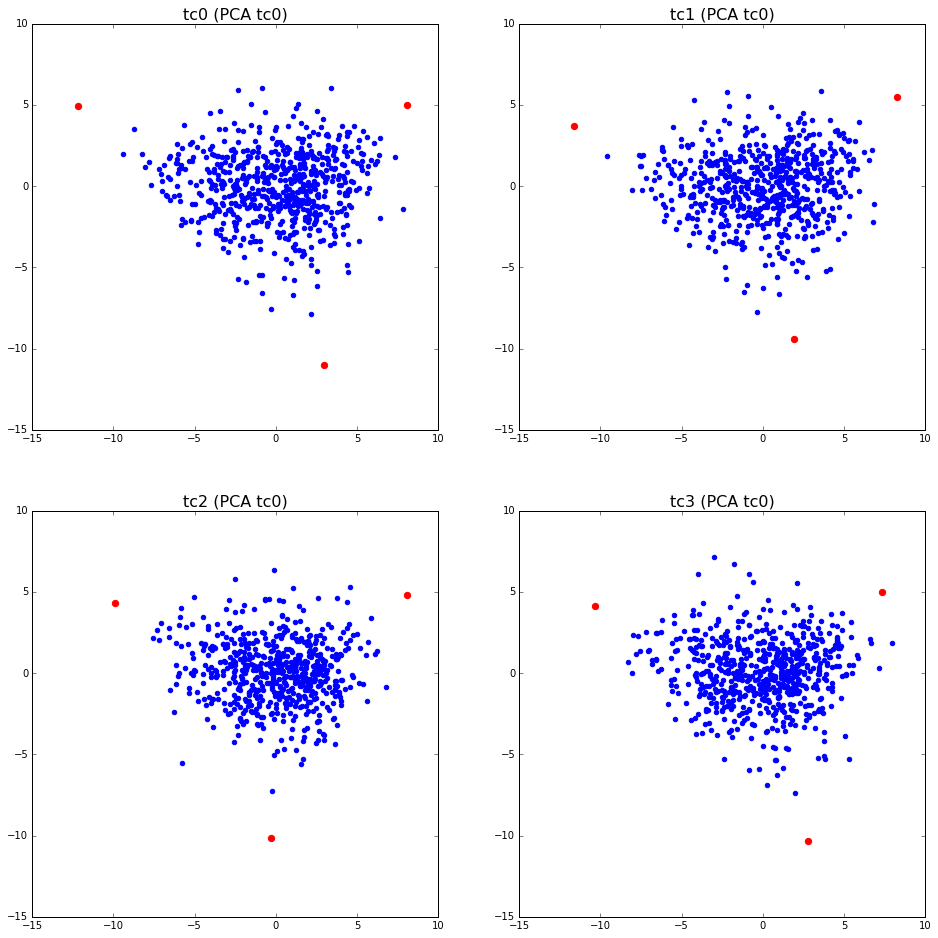

In [100]:
plt.figure(figsize=(16,16))

plt.subplot(2,2,1)
plt.title("tc0 (PCA tc0)", fontsize=16)

X0 = X_users_mean_tc0_clean_svm.T
pca = decomposition.PCA(n_components=2).fit(X0.T)  # <------ Is only fitted here!
X0 = pca.transform(X0.T).T
XC, S, C, SSE, varexpl = PCHA(X0, 3, delta=0.4)

plt.scatter(X0[0, :], X0[1, :], color="b")
plt.scatter(XC[0, :], XC[1, :], color="r", s=40)


plt.subplot(2,2,2)
plt.title("tc1 (PCA tc0)", fontsize=16)

X0 = X_users_mean_tc1_clean_svm.T
X0 = pca.transform(X0.T).T
XC, S, C, SSE, varexpl = PCHA(X0, 3, delta=0.4)

plt.scatter(X0[0, :], X0[1, :], color="b")
plt.scatter(XC[0, :], XC[1, :], color="r", s=40)


plt.subplot(2,2,3)
plt.title("tc2 (PCA tc0)", fontsize=16)

X0 = X_users_mean_tc2_clean_svm.T
X0 = pca.transform(X0.T).T
XC, S, C, SSE, varexpl = PCHA(X0, 3, delta=0.4)

plt.scatter(X0[0, :], X0[1, :], color="b")
plt.scatter(XC[0, :], XC[1, :], color="r", s=40)


plt.subplot(2,2,4)
plt.title("tc3 (PCA tc0)", fontsize=16)

X0 = X_users_mean_tc3_clean_svm.T
X0 = pca.transform(X0.T).T
XC, S, C, SSE, varexpl = PCHA(X0, 3, delta=0.4)

plt.scatter(X0[0, :], X0[1, :], color="b")
plt.scatter(XC[0, :], XC[1, :], color="r", s=40)


plt.show()

# Pareto clustering

In [ ]:
%matplotlib inline
import numpy as np

from pareto_clustering.cluster.build_S import Build_S
from pareto_clustering.cluster import cluster_Infomap
from pareto_clustering.cluster import cluster_DBSCAN